<a href="https://colab.research.google.com/github/ruizleandro/Credit_Card_Default_Clients/blob/master/Credit_Card_Default_Clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary installations

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Downgrading Java so Spark works properly

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


###### Spark Installation

In [0]:
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(
    'portfolio_default_of_credit_card_clients').getOrCreate()

     |████████████████████████████████| 217.8MB 57kB/s 
     |████████████████████████████████| 204kB 39.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=240e50d03138325f92ac3b5bb6b51a075e7414250bd34973790dee9f23ae195c
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


# Getting the data

[Link to dataset's Kaggle page](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving default_of_credit_card_clients.xls to default_of_credit_card_clients.xls
User uploaded file "default_of_credit_card_clients.xls" with length 5539328 bytes


In [0]:
df = pd.read_excel("default_of_credit_card_clients.xls", skiprows=1)
df.set_index('ID', inplace=True)

# Data Cleaning

 ## Variable description

There are 25 variables:

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no)

## Feature edition

I'll change the name of the target column and the name of `PAY_0` to `PAY_1` just for simplicity sake.

In [0]:
df = df.rename(columns={'default payment next month': 'default', 
                        'PAY_0': 'PAY_1'})

In the variable description we can see that a value of `-1` on `PAY_N` means pay duly, so it has more sense if I change that value to `0`, meaning that the client doesn't have payment delay. And the value `-2` is undocumented, but we can guess that means the same as `-1`.

In [0]:
df.loc[df.PAY_1 == -2, 'PAY_1'] = 0
df.loc[df.PAY_1 == -1, 'PAY_1'] = 0
df.loc[df.PAY_2 == -2, 'PAY_2'] = 0
df.loc[df.PAY_2 == -1, 'PAY_2'] = 0
df.loc[df.PAY_3 == -2, 'PAY_3'] = 0
df.loc[df.PAY_3 == -1, 'PAY_3'] = 0
df.loc[df.PAY_4 == -2, 'PAY_4'] = 0
df.loc[df.PAY_4 == -1, 'PAY_4'] = 0
df.loc[df.PAY_5 == -2, 'PAY_5'] = 0
df.loc[df.PAY_5 == -1, 'PAY_5'] = 0
df.loc[df.PAY_6 == -2, 'PAY_6'] = 0
df.loc[df.PAY_6 == -1, 'PAY_6'] = 0

I am going to group the label `MARRIAGE = 0` (that is undocumented) with `MARRAIAGE = 3` (others). 

In [0]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

And I'll do the same with `EDUCATION = 0` (undocumented), `EDUCATION = 5` (unknown), and `EDUCATION = 6` (also unknown). I am going to group all this labels in `EDUCATION = 4` (others).

In [0]:
df.loc[(df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6),
       'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

# Exploratory Data Analysis

### Shape and quick look to the dataset

In [0]:
df.shape

(30000, 24)

In [0]:
df.head(10) 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,0,0,0,0,0,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

### Correlation Matrix

In [0]:
corr_matrix = df.corr()
corr_matrix['default'].sort_values(ascending=False)

default      1.000000
PAY_1        0.396019
PAY_2        0.327093
PAY_3        0.286999
PAY_4        0.269055
PAY_5        0.260850
PAY_6        0.244437
EDUCATION    0.033842
AGE          0.013890
BILL_AMT6   -0.005372
BILL_AMT5   -0.006760
BILL_AMT4   -0.010156
BILL_AMT3   -0.014076
BILL_AMT2   -0.014193
BILL_AMT1   -0.019644
MARRIAGE    -0.027575
SEX         -0.039961
PAY_AMT6    -0.053183
PAY_AMT5    -0.055124
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT2    -0.058579
PAY_AMT1    -0.072929
LIMIT_BAL   -0.153520
Name: default, dtype: float64

Heatmap of the correlation matrix:

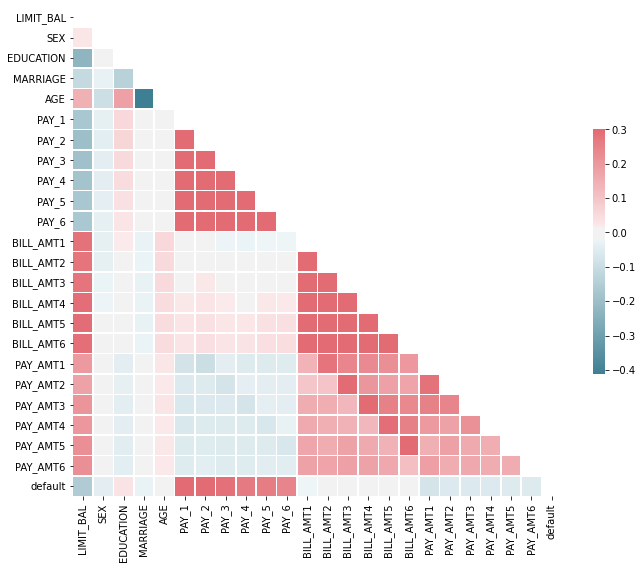

In [0]:
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Exploration

### Description of categorical features:

Here, I have to count the values of every categorical variabel (SEX, AGE, EDUCATION and MARRIAGE).

#### Gender

* 1 corresponds to MEN.
* 2 corresponds to WOMEN.

Value counts:

In [0]:
print(df.SEX.value_counts(), '\n')
print('Women are the', (sum(df.SEX == 2) * 100 / 30000), '% of the samples.')

2    18112
1    11888
Name: SEX, dtype: int64 

Women are the 60.373333333333335 % of the samples.


Default probabilities according to the gender of the clients:

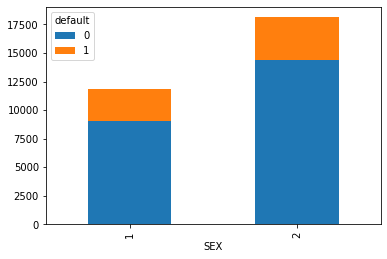

In [0]:
gender = df.groupby(['SEX', 'default']).size().unstack(1)
gender.plot(kind='bar', stacked = True)

In [0]:
gender['probability'] = (gender[1]/(gender[0] + gender[1]))
gender

default,0,1,probability
SEX,,,
1,9015,2873,0.241672
2,14349,3763,0.207763


We can see that men are 20 % more likely to default than women.



---



#### Education

* 1 corresponds to school graduated.
* 2 corresponds to university graduated.
* 3 corresponds to high school graduated.
* 4 corresponds to others.

Value counts:

In [0]:
print(df.EDUCATION.value_counts(), '\n')
print('The', (sum(df.EDUCATION == 1) * 100 / 30000), 
      '% of the clients are school graduates.')
print('The', (sum(df.EDUCATION == 2) * 100 / 30000), 
      '% of the clients are university graduates.')
print('The', (sum(df.EDUCATION == 3) * 100 / 30000), 
      '% of the clients are high school graduates.')
print('The', (sum(df.EDUCATION == 4) * 100 / 30000), 
      '% of the clients have other education level.')

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64 

The 35.28333333333333 % of the clients are school graduates.
The 46.766666666666666 % of the clients are university graduates.
The 16.39 % of the clients are high school graduates.
The 1.56 % of the clients have other education level.


Default probabilities according to education of the clients:

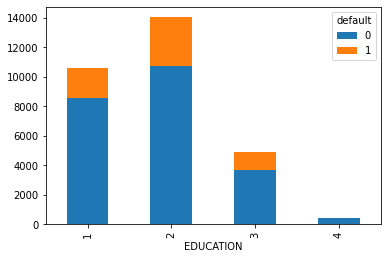

In [0]:
default_by_education = df.groupby(['EDUCATION', 'default']).size().unstack(1)
default_by_education.plot(kind='bar', stacked = True)

In [0]:
default_by_education['probability'] = (default_by_education[1]/
                                      (default_by_education[0] +
                                       default_by_education[1]))
default_by_education

default,0,1,probability
EDUCATION,,,
1,8549,2036,0.192348
2,10700,3330,0.237349
3,3680,1237,0.251576
4,435,33,0.070513


Surprisingly, we can see that clients that only completed high school are more likely to default than university graduates.



---



#### Marriage


* 1 corresponds to married clients.
* 2 corresponds to single clients.
* 3 corresponds to clients with other marital status.

Value counts:

In [0]:
print(df.MARRIAGE.value_counts(), '\n')
print('The', (sum(df.MARRIAGE == 1) * 100 / 30000), 
      '% of the clients are married.')
print('The', (sum(df.MARRIAGE == 2) * 100 / 30000), 
      '% of the clients are single.')
print('The', (sum(df.MARRIAGE == 3) * 100 / 30000), 
      '% of the clients have other marital status.')

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64 

The 45.53 % of the clients are married.
The 53.21333333333333 % of the clients are single.
The 1.2566666666666666 % of the clients have other marital status.


Default probabilities according to the marital status of the clients:

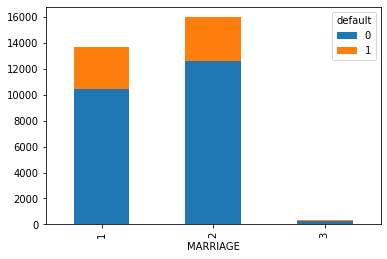

In [0]:
default_marriage = df.groupby(['MARRIAGE', 'default']).size().unstack(1)
default_marriage.plot(kind='bar', stacked = True)

In [0]:
default_marriage['probability'] = (default_marriage[1]/
                                  (default_marriage[0] + 
                                   default_marriage[1]))
default_marriage

default,0,1,probability
MARRIAGE,,,
1,10453,3206,0.234717
2,12623,3341,0.209283
3,288,89,0.236074


We can see that single clients have less probabilities of default than clients that are married or have other marital status.



---



### Numerical features

#### Age

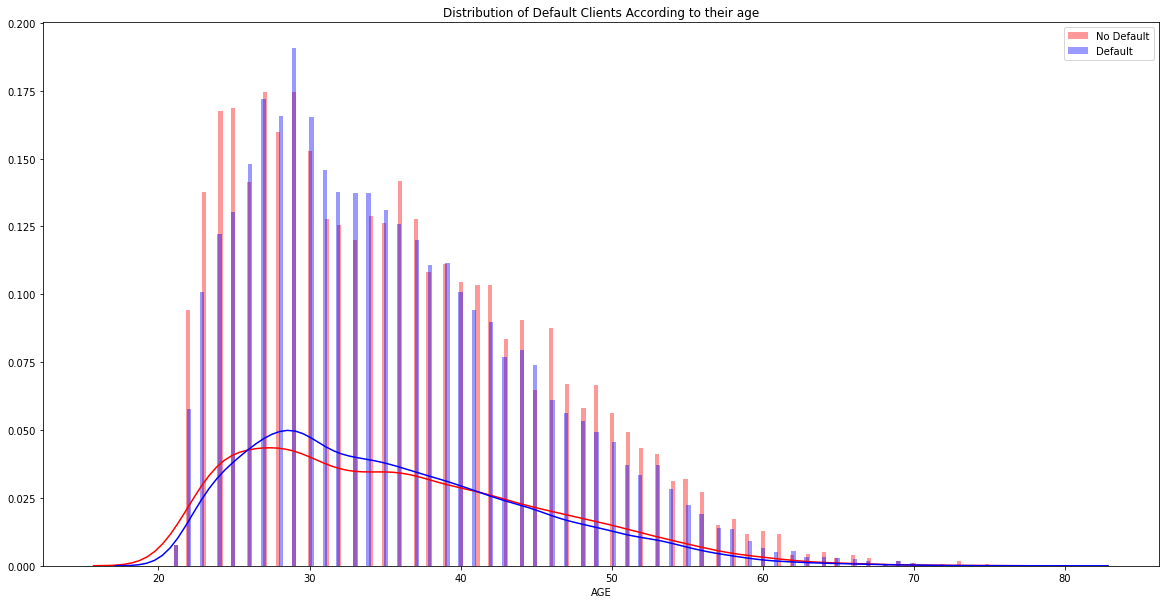

In [0]:
class_0 = df.loc[df['default'] == 0]["AGE"]
class_1 = df.loc[df['default'] == 1]["AGE"]
plt.figure(figsize = (20,10))
plt.title('Distribution of Default Clients According to their age')
sns.set_color_codes("pastel")
sns.distplot(class_1, kde=True, bins=200, color="red", label='No Default')
sns.distplot(class_0, kde=True, bins=200, color="blue", label='Default')
plt.legend()
plt.show()

#### Billing Amount

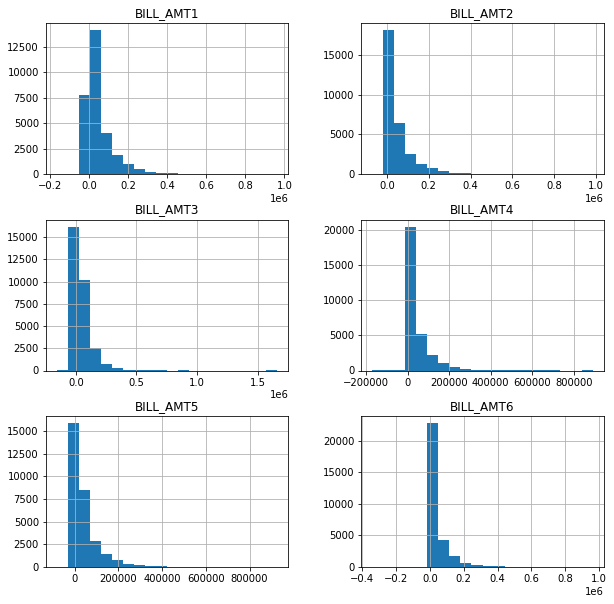

In [0]:
bills = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]

bills.hist(bins=20, figsize=(10,10))
plt.show()

#### Payment Amount

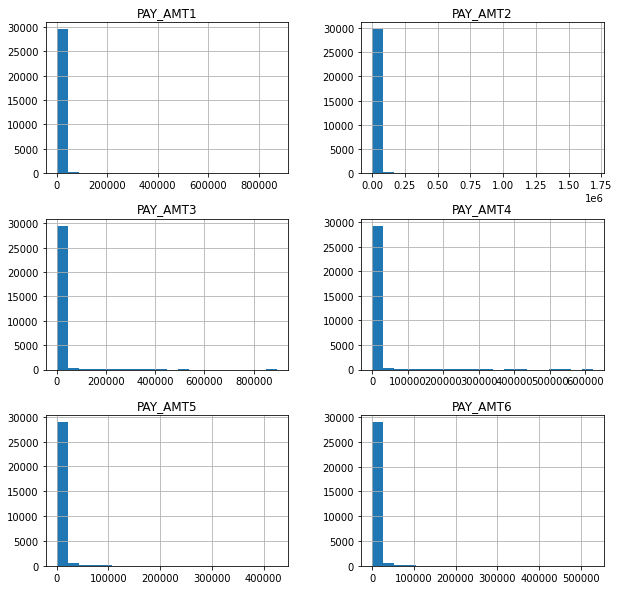

In [0]:
payments = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
payments.hist(bins=20, figsize=(10,10))
plt.show()

#### Months Owed

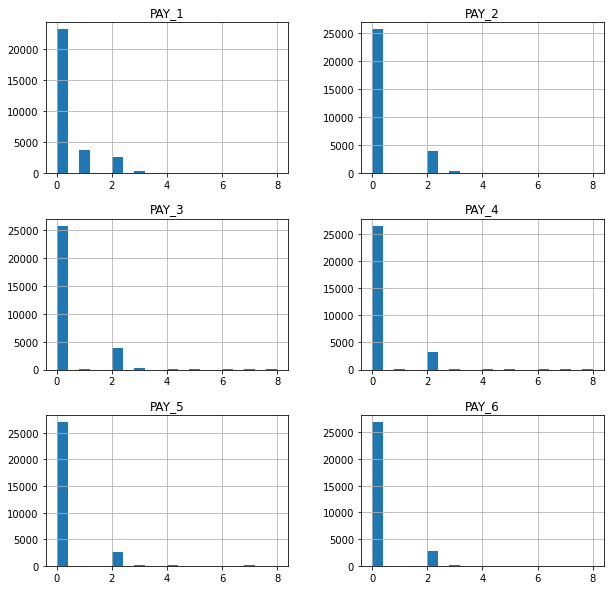

In [0]:
late = df[['PAY_1', 'PAY_2', 'PAY_3',
           'PAY_4', 'PAY_5', 'PAY_6']]

late.hist(bins=20, figsize=(10,10))
plt.show()

#### Default According to Credit Limit

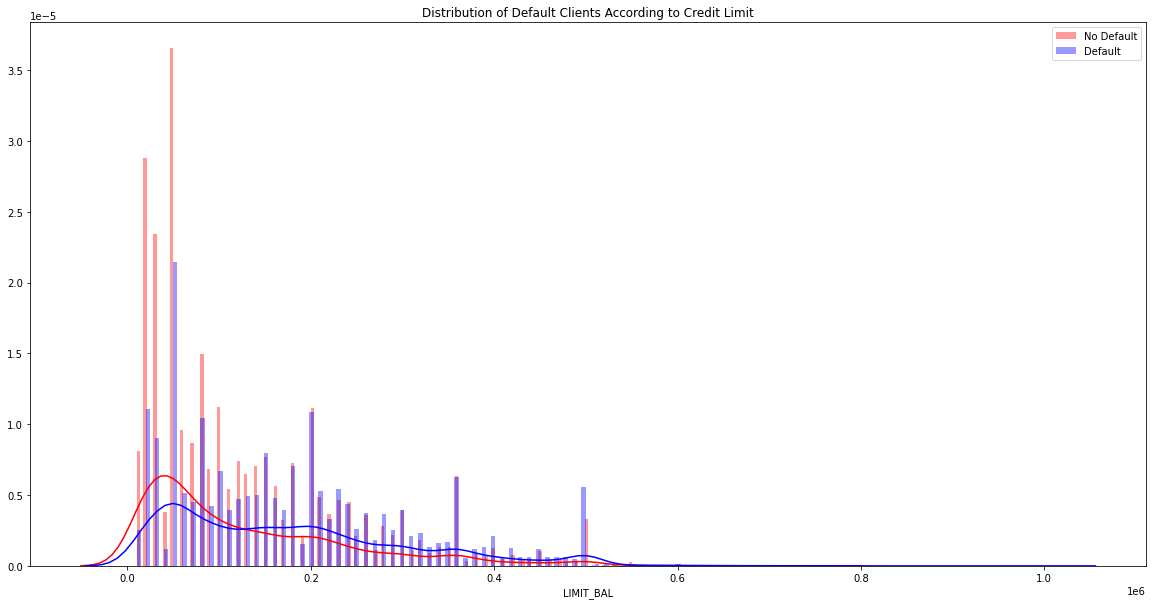

In [0]:
class_0 = df.loc[df['default'] == 0]["LIMIT_BAL"]
class_1 = df.loc[df['default'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (20,10))
plt.title('Distribution of Default Clients According to Credit Limit')
sns.set_color_codes("pastel")
sns.distplot(class_1, kde=True, bins=200, color="red", label='No Default')
sns.distplot(class_0, kde=True, bins=200, color="blue", label='Default')
plt.legend()
plt.show()

In this graph we can see that the proportion of defaults according to the credit limit starts to go up around the $10,000 limit (the bast majority is below this limit). Above that limit, more than the half of the clients end defaulting.

## Summary of the Exploratory Data Analysis

* Male clients and those who only are high school graduates are more prone to default their credit card payments.
* More than half of customers with a monthly limit of more than $ 10,000 ends up in default.
* You might think that younger clients would be more likely to default, but the data shows that clients in their 30s are the most likely to default.

# Data Preprocessing

The preprocessing of the data is a very important step before pass it through algorithm. We need to adjust the features of our set so that the data representation is more suitable for these algorithms. For example, some machine learning algorithms, like Neural Networks and Support Vector Machines, are very sensitive to the scaling of the data.

### Age Bining

Next, I'll bin the `age` feature so we have a good idea of to what age group every client belongs, but without having to deal with a lot of unique values.

In [0]:
df['AGE_BIN'] = pd.qcut(df['AGE'], 5)
df.AGE_BIN.value_counts()

(31.0, 37.0]      6728
(20.999, 27.0]    6604
(43.0, 79.0]      5986
(27.0, 31.0]      5626
(37.0, 43.0]      5056
Name: AGE_BIN, dtype: int64

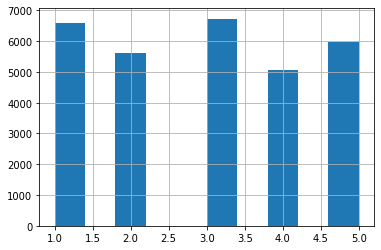

In [0]:
bins_names = [1, 2, 3, 4, 5]
df['AGE_BIN'] = pd.qcut(df['AGE'], 5, labels=bins_names)
df.AGE_BIN.hist()

### Encoding Categorical Variables

I need to encode the categorical features (that in this case have a numerical value), because as they are categories they lack of order against each other.

In [0]:
gender_dummies = pd.get_dummies(df.SEX, prefix='SEX')
education_dummies = pd.get_dummies(df.EDUCATION, prefix='EDUCATION')
marriage_dummies = pd.get_dummies(df.MARRIAGE, prefix='MARRIAGE')

binned_df = df.join(gender_dummies).join(education_dummies).join(
    marriage_dummies)

binned_df = binned_df.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
binned_df

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,AGE_BIN,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0
2,120000,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,1,0,1,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,3,0,1,0,1,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,3,0,1,0,1,0,0,1,0,0
5,50000,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,5,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,4,1,0,0,0,1,0,1,0,0
29997,150000,43,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,4,1,0,0,0,1,0,0,1,0
29998,30000,37,4,3,2,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,3,1,0,0,1,0,0,0,1,0


## Vector Assembler

Since I'm going to use Spark for model building, and their supervised learning algorithms need a data input with a special format. Where the dataframe has two columns: 'features', where all the features are condensed into a single dense vector representation. And 'label',  with the actual target class for every sample.

In [0]:
# enable apache_arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# create spark dataframe
df = spark.createDataFrame(binned_df)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion from Arrow: dictionary<values=int64, indices=int8, ordered=1>
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [0]:
from pyspark.ml.feature import VectorAssembler

df_assembler = VectorAssembler(inputCols=['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
                                          'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                          'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                                          'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                                          'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                                          'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                                          'AGE_BIN', 'SEX_1', 'SEX_2',
                                          'EDUCATION_1', 'EDUCATION_2',
                                          'EDUCATION_3', 'MARRIAGE_1',
                                          'MARRIAGE_2', 'MARRIAGE_3'],
                              outputCol='features')

df = df_assembler.transform(df)

In [0]:
df = df.withColumnRenamed('DEFAULT', 'label')

In [0]:
df.show(10, False)

+---------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------+-----+-----+-----------+-----------+-----------+-----------+----------+----------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|LIMIT_BAL|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|AGE_BIN|SEX_1|SEX_2|EDUCATION_1|EDUCATION_2|EDUCATION_3|EDUCATION_4|MARRIAGE_1|MARRIAGE_2|MARRIAGE_3|features                                                                                                                                                                                      |
+---------+---+-----+-----+-----+-----+-----+-----+---------+---------+-

In [0]:
model_df = df.select(['features', 'label'])

## Data Splitting

I am going to split the dataset into a training and test set.

In [0]:
train, test = model_df.randomSplit([0.75, 0.25])

# Model Selection

## Linear Regression Model



Notes:
* Make note of the coefficients.
* Perform GridSearchCV with
  * `penalty = l1, l2`
  * `class_weight = default, balanced`
  * `C = 0.1, 1, 10, 100`

First, I will use a simple binary classification algorithm: `LogisticRegression`.

I will use Apache Spark for the model building, mainly because is faster than the Scikit-Learn algorithms. 

### Model Training

In [0]:
from pyspark.ml.classification import LogisticRegression

logreg = LogisticRegression().fit(train)

### Model Performance on Training Set

In [0]:
lr_summary = logreg.summary
print('Accuracy:', lr_summary.accuracy)
print('Area under ROC:', lr_summary.areaUnderROC)
print('Precision by label:', lr_summary.precisionByLabel)
print('Recall by label:', lr_summary.recallByLabel)

Accuracy: 0.8177342086586231
Area under ROC: 0.7648728331628005
Precision by label: [0.8338145972319028, 0.6863303498779495]
Recall by label: [0.9559906387350876, 0.33572139303482584]


### Model Performance on Test Set

In [0]:
predictions = logreg.transform(test)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(29,[0,1,2,3,4,5,...|    1|[-8.1533612764758...|[2.87683683804101...|       1.0|
|(29,[0,1,2,3,4,5,...|    0|[-3.3510082571015...|[0.03386216299960...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-1.8569362717659...|[0.13506055424208...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-3.6610264516726...|[0.02506186983648...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-3.5135240120252...|[0.02892987148319...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-3.0724264244805...|[0.04425907574944...|       1.0|
|(29,[0,1,2,3,4,5,...|    0|[-2.1248866098561...|[0.10670140138269...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-3.3153922391654...|[0.03504690322851...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-1.2013503590537...|[0.23123508224278...|       1.0|
|(29,[0,1,2,3,4,

In [0]:
model_pred = logreg.transform(test)

#### Performance Metrics

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_auroc = lr_evaluator.evaluate(model_pred)
print(f'The auroc value of LogReg model is {lr_auroc}')

The auroc value of LogReg model is 0.7524069180075573


In [0]:
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
lr_aupr = lr_evaluator.evaluate(model_pred)
print(f'The aupr value of LogReg model is {lr_aupr}') 

The aupr value of LogReg model is 0.518103117980912


##### Recall and Precision:

In [0]:
true_pos = model_pred.filter(model_pred['label']==0).filter(
    model_pred['prediction']==0).count()
print(true_pos)

actual_pos = model_pred.filter(model_pred['label']==0).count()
print(actual_pos)

pred_pos = model_pred.filter(model_pred['prediction']==0).count()
print(pred_pos)

5590
5845
6662


Recall:

In [0]:
float(true_pos)/(actual_pos)

0.9563729683490163

Precision:

In [0]:
float(true_pos)/(pred_pos)

0.8390873611528069

## Support Vector Machines Model

### Model Training

In [0]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC()
lsvc_model = lsvc.fit(train)

model_pred = lsvc_model.transform(test)
model_pred.columns

['features', 'label', 'rawPrediction', 'prediction']

### Model Performance on Test Set

In [0]:
model_pred.select(['label', 'prediction']).show(10, False)

+-----+----------+
|label|prediction|
+-----+----------+
|1    |1.0       |
|0    |1.0       |
|1    |1.0       |
|1    |1.0       |
|1    |1.0       |
|1    |1.0       |
|0    |1.0       |
|1    |1.0       |
|1    |1.0       |
|1    |1.0       |
+-----+----------+
only showing top 10 rows



In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
svc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
svc_auroc = svc_evaluator.evaluate(model_pred)
print(f'The auc value of SVC is {svc_auroc}')

The auc value of SVC is 0.7430469733584119


In [0]:
svc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
svc_aupr = svc_evaluator.evaluate(model_pred)
print(f'The aupr value for SVC is {svc_aupr}')

The aupr value for SVC is 0.5080728765011508


#### Recall and Precision

In [0]:
true_pos = model_pred.filter(model_pred['label']==1).filter(
    model_pred['prediction']==1).count()
print(true_pos)

actual_pos = model_pred.filter(model_pred['label']==1).count()
print(actual_pos)

pred_pos = model_pred.filter(model_pred['prediction']==1).count()
print(pred_pos)

627
1611
961


In [0]:
# Recall
print('Recall:', (float(true_pos)/(actual_pos)))
# Precision
print('Precision:', (float(true_pos)/(pred_pos)))

Recall: 0.3891992551210428
Precision: 0.6524453694068678


## Random Forest Model

### Model Training

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=50, maxDepth=30)
rf_model = rf.fit(train)

### Model Performance on Test Set

In [0]:
model_pred = rf_model.transform(test)
model_pred.select(['label', 'probability', 'prediction']).show(10, False)

+-----+-----------------------------------------+----------+
|label|probability                              |prediction|
+-----+-----------------------------------------+----------+
|1    |[0.5771428571428572,0.4228571428571428]  |0.0       |
|0    |[0.11683181225554107,0.8831681877444589] |1.0       |
|1    |[0.2207571868809157,0.7792428131190843]  |1.0       |
|1    |[0.021457186880915694,0.9785428131190844]|1.0       |
|1    |[0.04309052021424902,0.9569094797857509] |1.0       |
|1    |[0.10309052021424904,0.896909479785751]  |1.0       |
|0    |[0.044090520214249015,0.955909479785751] |1.0       |
|1    |[0.003090520214249028,0.996909479785751] |1.0       |
|1    |[0.5152444444444444,0.4847555555555555]  |0.0       |
|1    |[0.0,1.0]                                |1.0       |
+-----+-----------------------------------------+----------+
only showing top 10 rows



In [0]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(model_pred)
print(f'The area under ROC value of Random Forest Classifier Model is {rf_auroc}')

The area under ROC value of Random Forest Classifier Model is 0.7596364599877157


In [0]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(model_pred)
print(f'The area under PR value of Random Forest Classifier Model is {rf_aupr}')

The area under PR value of Random Forest Classifier Model is 0.5209617165888759


##### Recall and Precision

In [0]:
true_pos = model_pred.filter(model_pred['label']==1).filter(
    model_pred['prediction']==1).count()
print('True positives:', true_pos)

actual_pos = model_pred.filter(model_pred['label']==1).count()
print('Actual positives:', actual_pos)

pred_pos = model_pred.filter(model_pred['prediction']==1).count()
print('Predicted positives:', pred_pos)

True positives: 593
Actual positives: 1611
Predicted positives: 929


In [0]:
# Recall
float(true_pos)/(actual_pos)

0.3680943513345748

In [0]:
# Precision
float(true_pos)/(pred_pos)

0.6383207750269106

# Hyperparameter-Tuning

Select the best model using GridSearchCV and CrossValidation.

## Random Forest Classifier Model

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().
             addGrid(rf.maxDepth, [10, 20, 30]).
             addGrid(rf.maxBins, [20, 60]).
             addGrid(rf.numTrees, [10, 30, 50]).
             build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                    evaluator=rf_evaluator, numFolds=5)
cv_model = cv.fit(train)
best_rf_model = cv_model.bestModel

# Final Test of the Model

In [0]:
model_prediction = best_rf_model.transform(test)

rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(model_prediction)
print(f'The auc value of Random Forest Classifier Model is {rf_auroc}')

rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(model_prediction)
print(f'The aupr value of Random Forest Classifier Model is {rf_aupr}')

The auc value of Random Forest Classifier Model is 0.7692255818238487
The aupr value of Random Forest Classifier Model is 0.544139240900792


In [0]:
true_pos = model_prediction.filter(model_prediction['label']==1).filter(
    model_prediction['prediction']==1).count()
print('True positives:', true_pos)

actual_pos = model_prediction.filter(model_prediction['label']==1).count()
print('Actual positives:', actual_pos)

pred_pos = model_prediction.filter(model_prediction['prediction']==1).count()
print('Predicted positives:', pred_pos)

True positives: 587
Actual positives: 1611
Predicted positives: 873


In [0]:
# Recall
float(true_pos)/(actual_pos)

0.3643699565487275

In [0]:
# Precision
float(true_pos)/(pred_pos)

0.6723940435280642

# Summary

# Future Work/Next Steps